In [1]:
# 基本ライブラリ
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import numpy.random as rd
import gc
import multiprocessing as mp
import os
import sys
import pickle
from collections import defaultdict
from glob import glob
import math
from datetime import datetime as dt
from pathlib import Path
import scipy.stats as st
import re
import shutil
from tqdm import tqdm_notebook as tqdm
import datetime
ts_conv = np.vectorize(datetime.datetime.fromtimestamp) # 秒ut(10桁) ⇒ 日付

# グラフ描画系
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

from matplotlib import animation as ani
from IPython.display import Image

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

#カラム内の文字数。デフォルトは50
pd.set_option("display.max_colwidth", 100)

#行数
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#
pd.options.display.float_format = '{:,.5f}'.format

%matplotlib inline

In [2]:

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold

from sklearn import metrics
import json

import warnings
warnings.filterwarnings("ignore")


sys.path.append('..')
from lib.line_notif import send_message
#from lib.utils import matrics_rotate
from lib.utils import reduce_mem_usage, current_time, unpickle, to_pickle
from lib.utils import one_hot_encoder, apply_agg, multi_combine_categorical_feature
from lib.utils import import_data, get_split_indexer 

In [3]:


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true - y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [4]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
structures = pd.read_csv('../input/structures.csv')

In [5]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [8]:
test_id = test.id.values

In [7]:
ls -l ../submit/v003_031/

total 1607136
-rw-r--r--@ 1 kenichi.matsui  1522739515  67160895  6 28 08:35 submission_t_v003_031_10.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67161182  6 28 08:35 submission_t_v003_031_11.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67169888  6 28 08:35 submission_t_v003_031_12.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67163912  6 28 08:35 submission_t_v003_031_1238.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67163624  6 28 08:35 submission_t_v003_031_1239.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67163913  6 28 08:35 submission_t_v003_031_1240.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67161997  6 28 08:35 submission_t_v003_031_2029.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67163224  6 28 08:35 submission_t_v003_031_2030.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67162681  6 28 08:35 submission_t_v003_031_2031.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67163306  6 28 08:36 submission_t_v003_031_81.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67162906  6 

In [14]:
sub_files = np.sort(glob("../submit/v003_024/submission_t_v003_024_*.csv")).tolist() + \
            np.sort(glob("../submit/v003_031/submission_t_v003_031_*.csv")).tolist() + \
            np.sort(glob("../submit/v003_036/submission_t_v003_036_*.csv")).tolist()
#sub_files += ["../submit/v003_021/submission_t_v003_021.csv"]
len(sub_files)

56

In [6]:
sub_files

['../submit/v003_024/submission_t_v003_024_0.csv',
 '../submit/v003_024/submission_t_v003_024_1.csv',
 '../submit/v003_024/submission_t_v003_024_1228.csv',
 '../submit/v003_024/submission_t_v003_024_1229.csv',
 '../submit/v003_024/submission_t_v003_024_1230.csv',
 '../submit/v003_024/submission_t_v003_024_1231.csv',
 '../submit/v003_024/submission_t_v003_024_1879.csv',
 '../submit/v003_024/submission_t_v003_024_1880.csv',
 '../submit/v003_024/submission_t_v003_024_1988.csv',
 '../submit/v003_024/submission_t_v003_024_1989.csv',
 '../submit/v003_024/submission_t_v003_024_2.csv',
 '../submit/v003_024/submission_t_v003_024_2019.csv',
 '../submit/v003_024/submission_t_v003_024_2020.csv',
 '../submit/v003_024/submission_t_v003_024_2021.csv',
 '../submit/v003_024/submission_t_v003_024_2022.csv',
 '../submit/v003_024/submission_t_v003_024_3.csv',
 '../submit/v003_024/submission_t_v003_024_3018.csv',
 '../submit/v003_024/submission_t_v003_024_3019.csv',
 '../submit/v003_024/submission_t_v003_0

In [15]:
sub_list = [pd.read_csv(f, index_col=0).loc[test_id] for f in sub_files]

In [16]:
submit_list_df = pd.concat(sub_list, axis=1)
submit_list_df["mean_score"] = submit_list_df.mean(axis=1).values

In [17]:
submit_list_df.shape, test.shape

((2505542, 57), (2505542, 5))

In [18]:
submit_list_df.head()

,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,mean_score
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4658147,14.42941,17.94441,17.13644,15.27704,18.12263,11.16509,15.10848,11.30809,16.10830,10.45234,17.09311,15.45748,14.73881,17.00781,17.35652,15.09924,14.48620,11.58494,16.53874,11.38786,16.53289,11.65432,11.89966,13.16861,16.66891,17.96141,17.95364,15.25749,15.98762,17.28167,16.45448,16.11573,16.03340,16.98255,17.62068,17.10367,17.74341,17.56850,17.78834,18.22905,16.96251,16.93125,18.65182,18.19419,17.77122,17.36248,17.87813,16.72704,17.99861,16.49464,17.85248,17.80312,19.48712,17.23731,16.73056,18.13795,16.17910
4658148,185.88040,189.22815,177.96684,178.29521,174.17156,186.59956,189.48546,172.57653,185.81137,172.15734,187.75813,190.59805,176.24125,176.60991,189.97100,173.97079,189.41381,171.46370,176.38060,188.38959,188.68883,175.30350,189.59037,190.87225,189.00259,191.26320,188.83835,190.98393,189.50910,190.54683,190.54329,191.82643,191.07247,190.02328,190.38246,191.41840,189.30333,188.74001,189.28737,192.11641,191.54429,190.56128,189.09340,189.87708,192.40682,191.77691,193.53000,190.85474,188.64164,191.73558,189.90895,188.66641,189.52551,191.58155,190.62860,190.16190,187.01386
4658149,3.09688,2.21603,1.15874,1.07824,1.98580,1.94886,1.08236,2.05203,1.18298,1.41101,2.87073,1.70897,1.95319,1.57943,2.10752,2.97226,2.11981,2.51997,1.59662,1.80854,1.92023,1.77562,1.79195,2.19322,1.76801,2.01224,3.44801,0.49343,1.83392,3.14588,1.29609,2.47671,3.24312,0.57838,2.40776,3.13108,2.19918,0.85278,1.16794,0.70090,2.61150,0.75378,1.54877,0.69565,2.06642,0.88837,1.28472,1.30951,2.09427,1.86140,1.70428,1.74494,1.55909,0.56952,1.02250,2.00932,1.79661
4658150,185.21704,187.47601,177.79644,177.43159,174.34333,187.66521,187.79254,172.67824,185.47784,173.02363,186.61189,189.29749,175.51608,175.60289,188.88495,174.97048,188.24557,172.21388,175.36830,187.60289,188.39261,174.64212,188.22205,191.36174,185.01688,188.96020,188.38211,189.44883,186.80611,189.85659,188.88388,189.62517,190.25664,189.52506,189.65012,189.74856,187.87864,187.94630,188.78664,189.58303,189.91478,189.58875,187.75942,187.41612,191.11933,188.42243,189.47752,188.16647,187.32914,189.94102,189.09360,186.40811,188.13127,189.71160,188.88455,188.56789,185.82360
4658151,11.23099,11.92204,10.61515,9.89115,9.65368,9.22986,10.09855,8.92606,10.62795,8.22679,10.37771,10.08616,11.51516,10.30362,11.01774,11.24645,11.14516,9.10557,10.00420,10.12544,10.08545,10.91471,10.47740,7.81167,14.25185,15.03146,16.22995,7.11903,8.56169,13.83618,13.26565,8.89741,14.22953,10.56753,11.57218,14.74232,13.60409,17.42783,11.34033,17.48116,10.84413,15.89535,17.67403,17

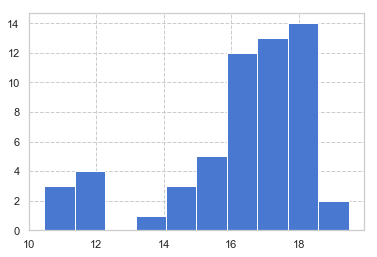

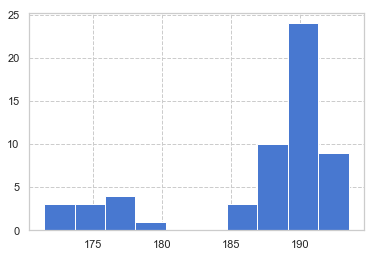

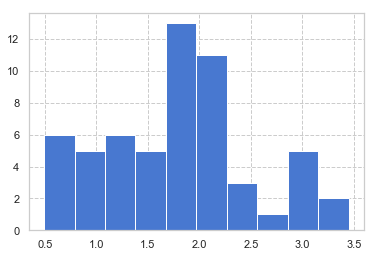

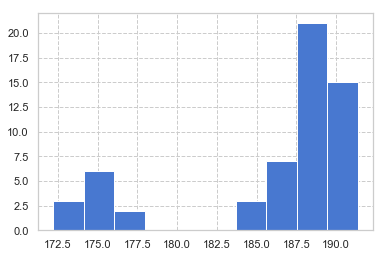

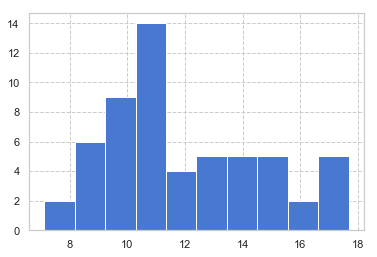

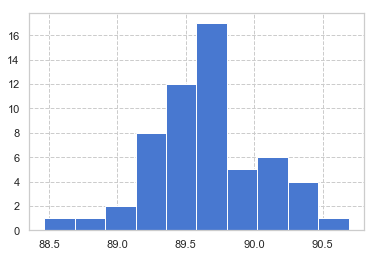

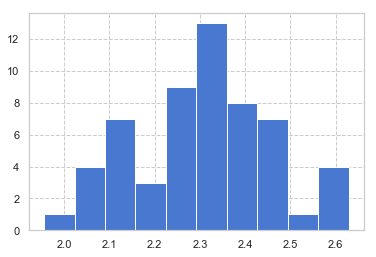

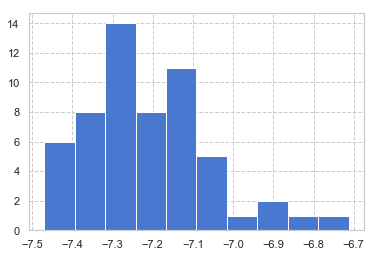

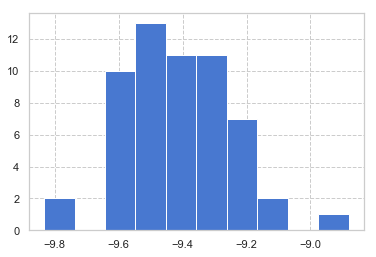

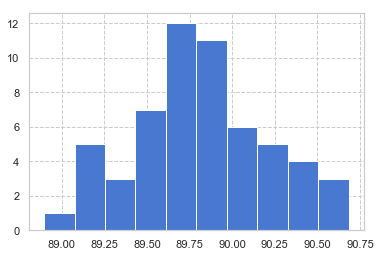

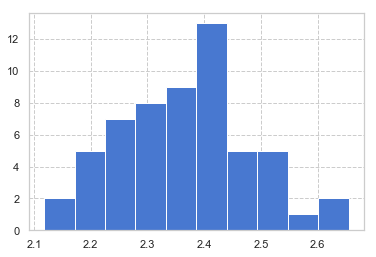

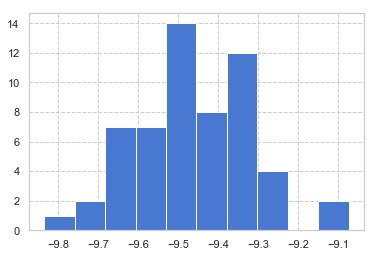

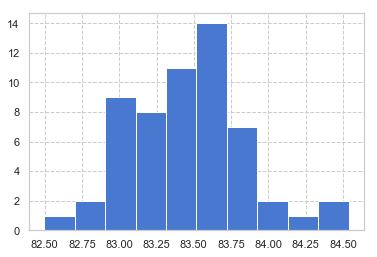

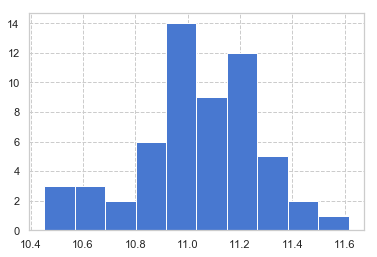

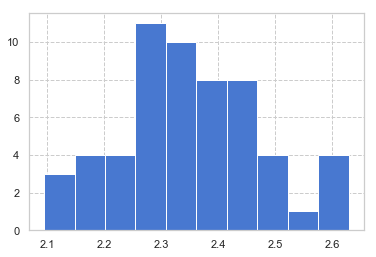

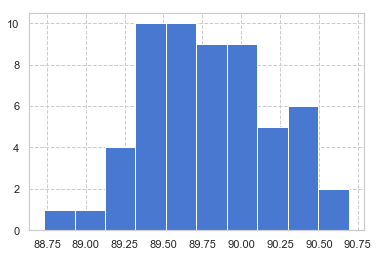

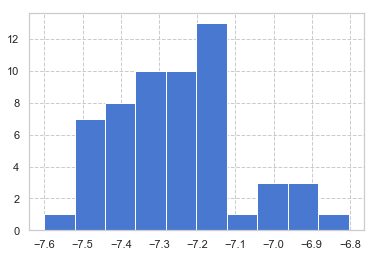

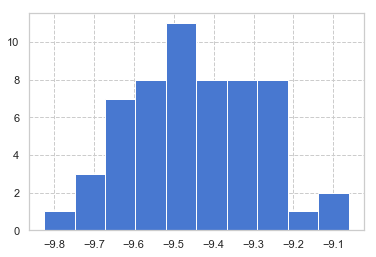

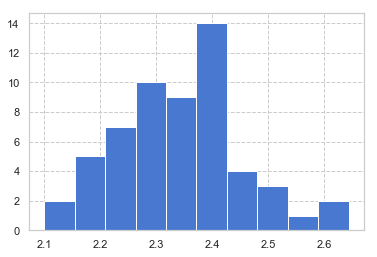

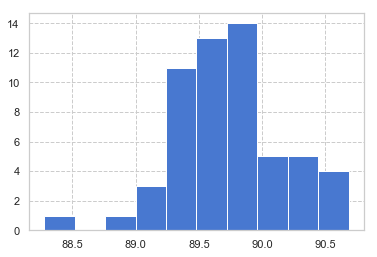

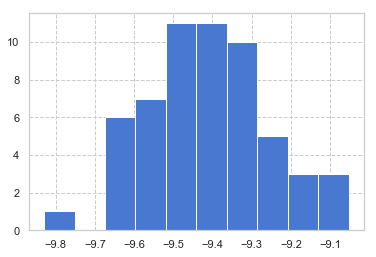

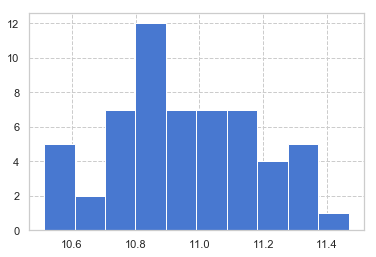

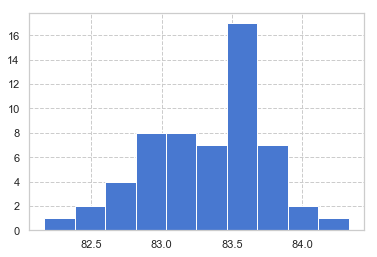

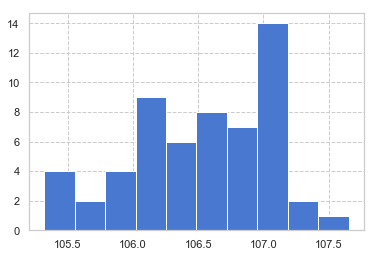

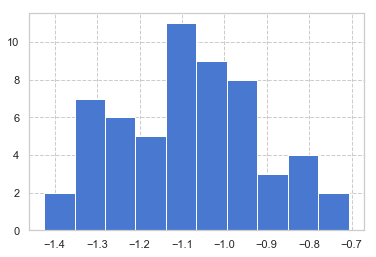

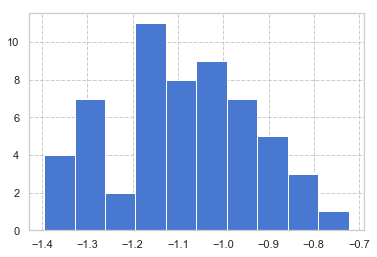

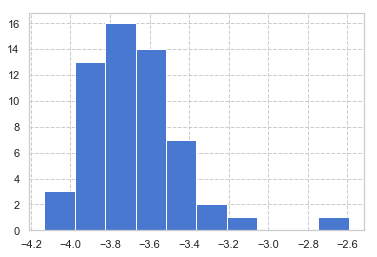

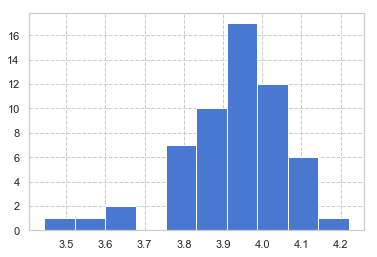

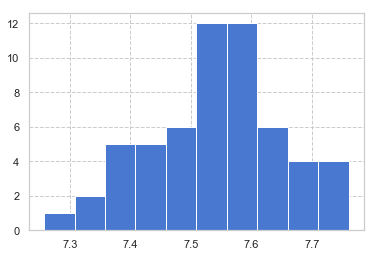

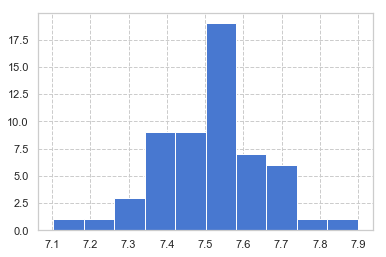

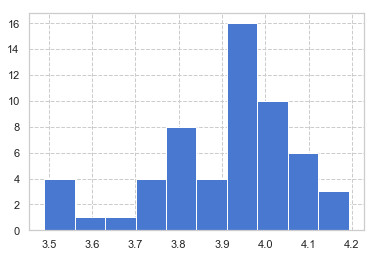

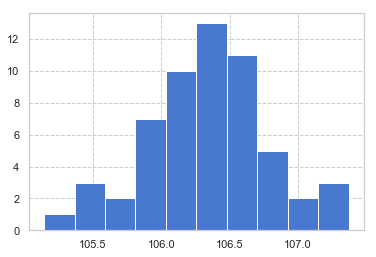

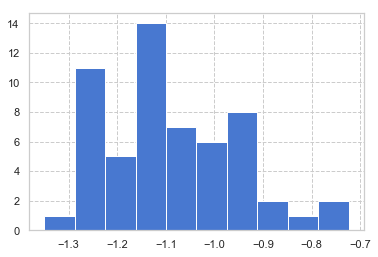

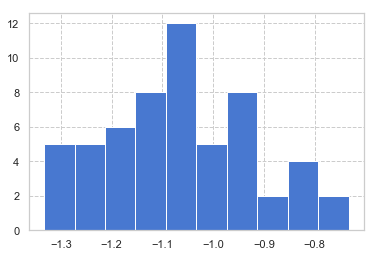

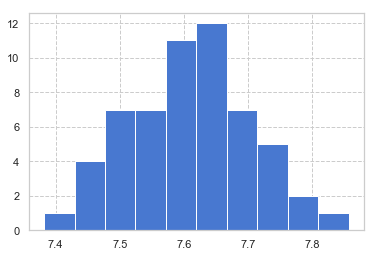

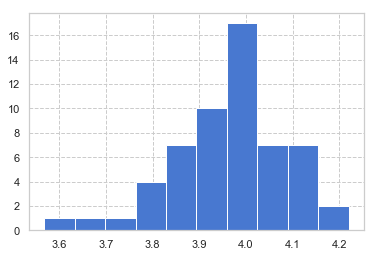

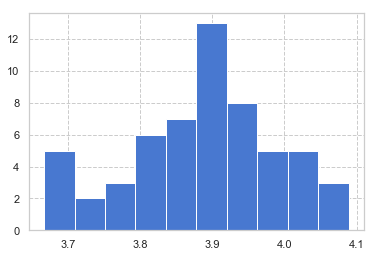

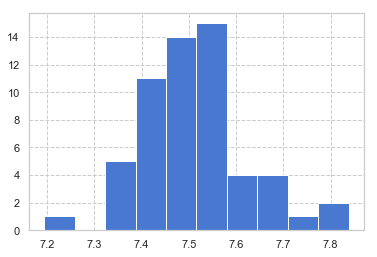

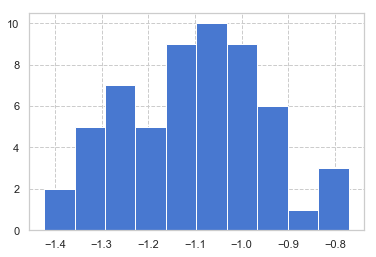

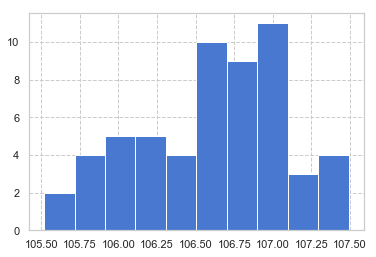

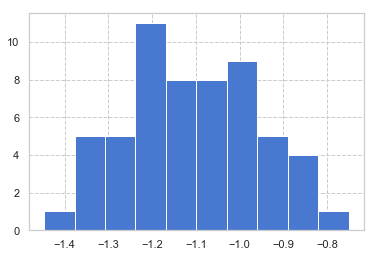

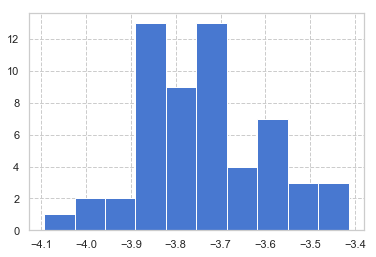

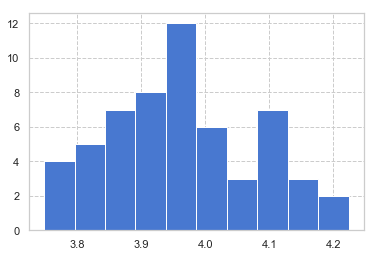

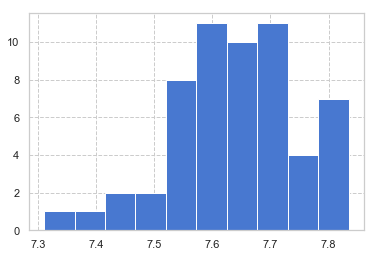

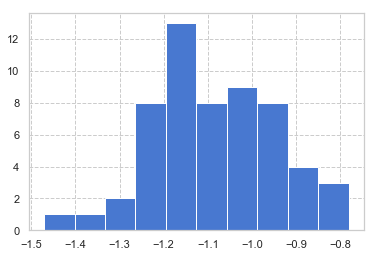

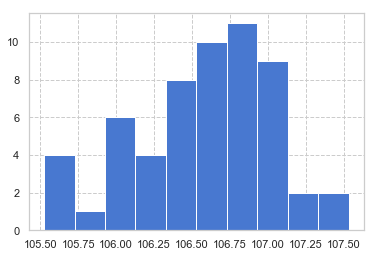

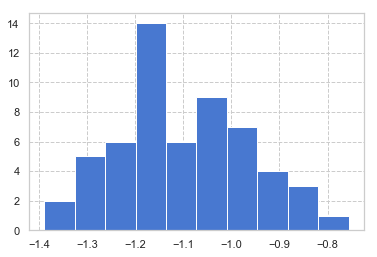

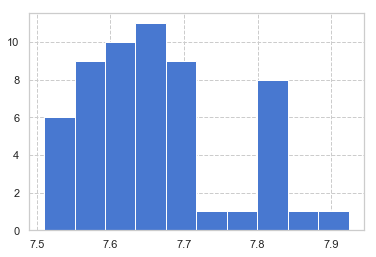

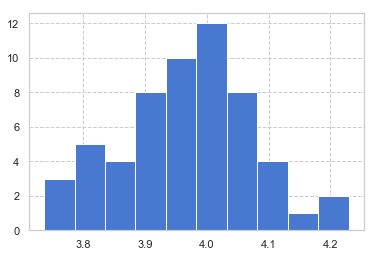

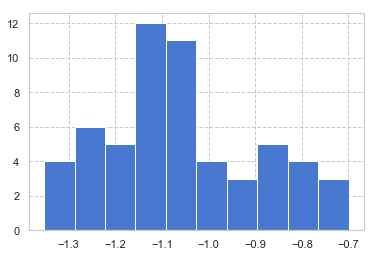

In [21]:
for i, d in submit_list_df.head(50).iterrows():
    d.hist()
    plt.show()

In [29]:
submit_list_df.iloc[:, :len(sub_files)].corr()

,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant
scalar_coupling_constant,1.00000,0.99997,0.99997,0.99998,0.99997,0.99997,0.99997
scalar_coupling_constant,0.99997,1.00000,0.99997,0.99997,0.99998,0.99997,0.99997
scalar_coupling_constant,0.99997,0.99997,1.00000,0.99997,0.99997,0.99997,0.99997
scalar_coupling_constant,0.99998,0.99997,0.99997,1.00000,0.99997,0.99997,0.99997
scalar_coupling_constant,0.99997,0.99998,0.99997,0.99997,1.00000,0.99997,0.99997
scalar_coupling_constant,0.99997,0.99997,0.99997,0.99997,0.99997,1.00000,0.99997
scalar_coupling_constant,0.99997,0.99997,0.99997,0.99997,0.99997,0.99997,1.00000


In [32]:
sampled_id = submit_list_df.sample(frac=0.1).index.values

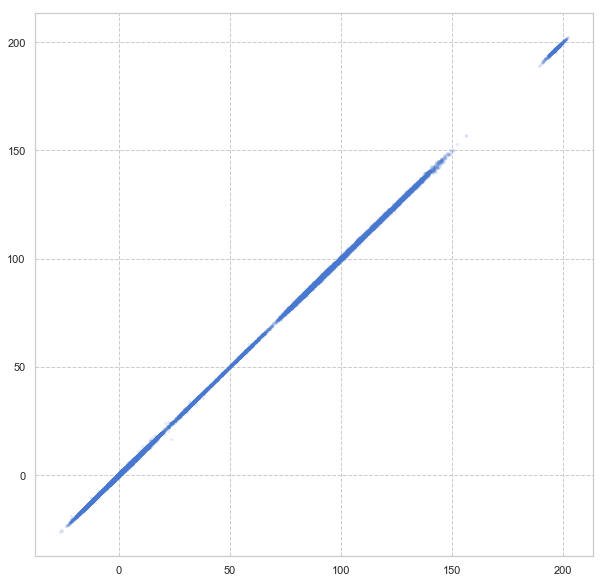

In [33]:
plt.figure(figsize=(10,10))
plt.scatter(x=submit_list_df.iloc[:, 0].loc[sampled_id], 
            y=submit_list_df.iloc[:, 7].loc[sampled_id], alpha=0.1, s= 5)

In [34]:
submit_df = submit_list_df[["mean_score"]]
submit_df.columns = ["scalar_coupling_constant"]

In [35]:
submit_df.head()

,scalar_coupling_constant
id,
4658147,17.82186
4658148,189.98512
4658149,1.57210
4658150,188.37540
4658151,14.85111


In [17]:
Path("../submit/ensemble").mkdir(parents=True, exist_ok=True)

In [36]:
submit_df.to_csv(f'../submit/v003_036/blending_v003_036_{len(sub_files)}seeds.csv', index=True)

In [37]:
!head ../submit/v003_036/blending_v003_036_7seeds.csv

id,scalar_coupling_constant
4658147,17.821861772782878
4658148,189.9851179381496
4658149,1.5721043387489118
4658150,188.37540384819172
4658151,14.851107208437714
4658152,89.85826273926959
4658153,2.4612248993776764
4658154,-7.282364295900067
4658155,-9.450810001436208


In [19]:
!head ../submit/v003_031/blending_v003_031_12seeds.csv

id,scalar_coupling_constant
4658147,16.78510438035354
4658148,190.450860821364
4658149,2.152886315810938
4658150,188.84668086684405
4658151,12.358732921154862
4658152,89.6457865393752
4658153,2.1958757115987484
4658154,-7.160083119140391
4658155,-9.34539337020452


In [69]:
!head ../submit/v003_024/blending_v003_024_20seeds.csv


id,scalar_coupling_constant
4658147,14.679174401717216
4658148,182.63303658380607
4658149,1.9250234806399167
4658150,182.03957686059215
4658151,10.23774837853997
4658152,89.54285148924419
4658153,2.263110256986365
4658154,-7.17705463691261
4658155,-9.410615272922424


In [70]:
!head ../submit/v003_024/blending_v003_024_14seeds.csv

id,scalar_coupling_constant
4658147,14.353976423109984
4658148,183.10524217370786
4658149,1.737910916691683
4658150,182.44727676700177
4658151,10.11133708598861
4658152,89.58719008504241
4658153,2.242156641327718
4658154,-7.146588388196449
4658155,-9.350822712856004


In [38]:
ls -l ../submit/v003_036/

total 1182336
-rw-r--r--  1 kenichi.matsui  DENA\Domain Users  67161206  6 29 02:50 blending_v003_036_7seeds.csv
-rw-r--r--@ 1 kenichi.matsui  DENA\Domain Users  67162908  6 28 17:29 submission_t_v003_036_10.csv
-rw-r--r--@ 1 kenichi.matsui  DENA\Domain Users  67161559  6 28 17:30 submission_t_v003_036_11.csv
-rw-r--r--@ 1 kenichi.matsui  DENA\Domain Users  67160941  6 29 01:42 submission_t_v003_036_20.csv
-rw-r--r--@ 1 kenichi.matsui  DENA\Domain Users  67160987  6 28 17:29 submission_t_v003_036_2029.csv
-rw-r--r--@ 1 kenichi.matsui  DENA\Domain Users  67162881  6 28 17:30 submission_t_v003_036_2030.csv
-rw-r--r--@ 1 kenichi.matsui  DENA\Domain Users  67170142  6 29 02:22 submission_t_v003_036_21.csv
-rw-r--r--@ 1 kenichi.matsui  DENA\Domain Users  67161887  6 29 01:43 submission_t_v003_036_22.csv


In [21]:
# !kaggle competitions submit -c champs-scalar-coupling -f ../submit/v003_036/blending_v003_036_7seeds.csv -m "blending all data v003_037 7 seeds."

100%|██████████████████████████████████████| 64.1M/64.1M [00:12<00:00, 5.45MB/s]
Successfully submitted to Predicting Molecular Properties

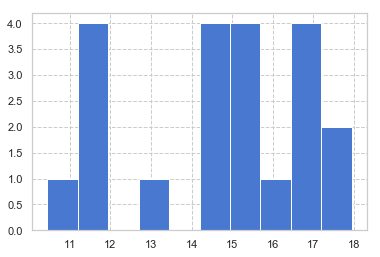

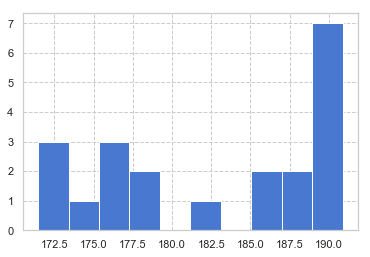

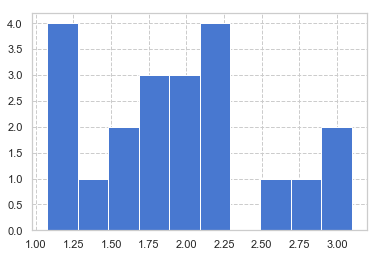

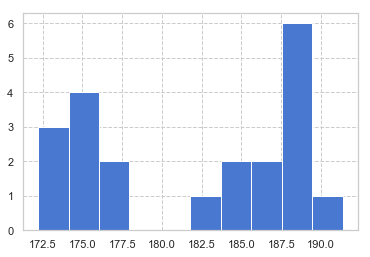

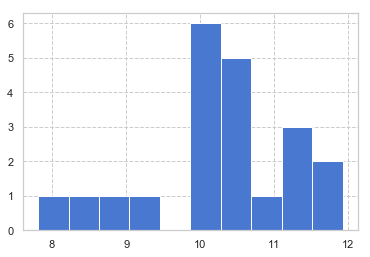

In [33]:
for i, d in submit_list_df.head().iterrows():
    d.hist()
    plt.show()

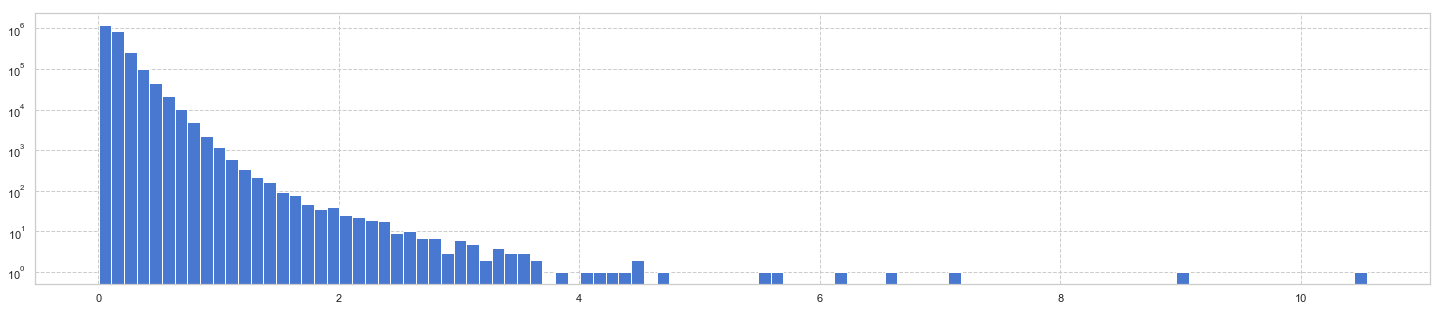

In [59]:

plt.figure(figsize=(25,5))
ax = plt.subplot(111)
cv_std.hist(ax=ax, bins=100)
plt.yscale("log")

In [38]:
cv_std = submit_list_df.std(axis=1)
cv_mean = submit_list_df.mean(axis=1)
cv_value = cv_std/cv_mean

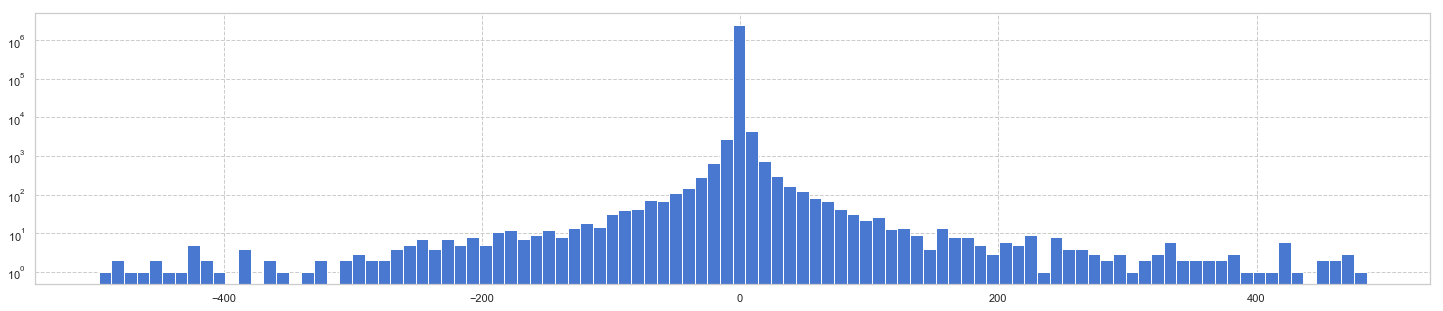

In [51]:
plt.figure(figsize=(25,5))
ax = plt.subplot(111)
cv_value[np.abs(cv_value) < 500].hist(ax=ax, bins=100)
plt.yscale("log")

In [47]:
np.abs(cv_value).sort_values(ascending=False)[:10]

id
5412746   219,716.34590
5465807   126,850.04206
5546431    85,100.91446
6552445    60,056.74870
5436786    18,762.42936
6942259    16,531.30469
4989294    13,911.01801
6462400    10,928.18863
4993772    10,377.60660
6114912     9,173.00372
dtype: float64

In [53]:
high_cv = cv_value[np.abs(cv_value) > 500]
high_cv

id
4698369     -6,946.80593
4710913        784.91746
4823283        918.63092
4825478      3,784.50219
4853540        576.83325
4882092       -623.90341
4892956      2,308.43802
4902768     -3,048.53894
4921967        633.81338
4935801        901.29538
4989294    -13,911.01801
4993772     10,377.60660
5085605     -2,476.27122
5098336        810.44443
5124395       -829.80919
5156635        595.45082
5169103     -6,183.53375
5181557      1,101.13801
5212243     -6,319.13448
5219726        734.34349
5241459      1,389.43887
5247798     -1,082.86622
5254630        556.98296
5263450        949.86269
5264679     -3,482.49522
5267715     -1,060.28821
5272631      1,867.69635
5307174      1,155.11992
5308095      4,925.84640
5335302      1,355.83248
5338066      2,875.03888
5397576      1,180.83817
5398959     -1,424.92753
5403209       -877.26486
5412746   -219,716.34590
5415657     -1,024.71457
5435504     -1,063.17269
5436786     18,762.42936
5465807   -126,850.04206
5467389     -1,476.073

In [55]:
submit_list_df_ = submit_list_df.copy()

In [56]:
submit_list_df_["std_score"] = submit_list_df_.std(axis=1)

In [58]:
submit_list_df_.loc[high_cv.index]

,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,mean_score,std_score
id,,,,,,,,,,,,,,,,,,,,,,
4698369,-0.10891,0.20726,-0.19428,0.14164,0.10174,-0.10369,-0.11895,0.00188,-0.05684,-0.28368,0.19707,-0.10099,-0.11010,-0.20905,0.25207,0.25043,0.08866,0.02276,-0.20298,0.22548,-0.00002,0.16780
4710913,0.05207,0.08899,-0.15923,0.00470,-0.07532,-0.03570,-0.04131,-0.06193,-0.11053,-0.01497,0.12922,0.03613,0.09471,0.02362,0.05518,-0.02941,0.08073,-0.01844,0.06022,-0.07685,0.00009,0.07374
4823283,-0.11116,0.22432,-0.37545,0.60204,-0.13754,0.06240,0.20810,0.40585,-0.18211,0.04688,-0.19219,0.23043,-0.09052,0.17002,-0.45115,0.11842,0.21245,-0.58632,0.06607,-0.21436,0.00031,0.28427
4825478,-0.12516,0.18095,-0.14940,0.07228,0.02214,0.24390,-0.01154,-0.02196,-0.04942,-0.17620,-0.01985,-0.02738,0.14320,-0.24234,-0.01120,0.14124,-0.14500,0.06739,0.10497,0.00403,0.00003,0.12391
4853540,-0.15255,0.10124,-0.04742,-0.17721,0.16389,0.07497,0.10726,0.00017,-0.00006,0.29439,0.11748,0.14192,-0.06900,-0.02649,0.08587,-0.02954,0.00904,-0.21160,-0.26380,-0.11382,0.00024,0.13654
4882092,-0.06139,0.10911,-0.07718,-0.01266,-0.01576,0.05420,0.04878,0.04608,-0.06544,-0.01899,0.07845,-0.04549,-0.08414,0.01805,0.08898,0.01646,0.03799,0.01525,-0.02814,-0.10609,-0.00010,0.05986
4892956,0.13003,-0.04687,-0.26013,-0.14713,-0.15578,0.06756,-0.07169,0.21287,-0.07898,-0.16460,0.20092,0.13675,-0.02912,0.21120,0.01110,0.00870,-0.04994,0.03103,0.11166,-0.11639,0.00006,0.13327
4902768,-0.02569,-0.00599,0.01376,0.08220,0.12647,-0.11451,-0.00514,0.02718,-0.06584,-0.06934,0.02045,-0.06207,0.00658,0.05293,-0.03427,0.02239,0.01581,-0.07608,0.03884,0.05194,-0.00002,0.05731
4921967,-0.03500,-0.04545,-0.04124,0.03967,-0.00208,-0.05063,-0.07278,0.05059,0.05512,-0.05801,0.02634,-0.00415,-0.00704,0.07495,0.09477,0.01673,-0.01851,-0.05953,0.00821,0.02950,0.00007,0.04683


In [66]:
(cv_std>2).sum()

164

In [67]:
submit_list_df_[cv_std>2]

,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,mean_score,std_score
id,,,,,,,,,,,,,,,,,,,,,,
4658147,14.42941,17.94441,17.13644,15.27704,15.10848,11.30809,16.10830,10.45234,17.09311,15.45748,14.73881,17.00781,17.35652,15.09924,14.48620,11.58494,16.53874,11.38786,11.89966,13.16861,14.67917,2.25488
4658148,185.88040,189.22815,177.96684,178.29521,189.48546,172.57653,185.81137,172.15734,187.75813,190.59805,176.24125,176.60991,189.97100,173.97079,189.41381,171.46370,176.38060,188.38959,189.59037,190.87225,182.63304,7.13280
4658150,185.21704,187.47601,177.79644,177.43159,187.79254,172.67824,185.47784,173.02363,186.61189,189.29749,175.51608,175.60289,188.88495,174.97048,188.24557,172.21388,175.36830,187.60289,188.22205,191.36174,182.03958,6.64369
4659320,33.08035,34.81430,26.73043,29.23484,27.54208,28.06737,28.00276,27.18509,28.28530,35.14333,26.87740,35.11687,28.20407,29.13082,27.81241,28.90023,27.67827,34.55264,27.81805,28.13963,29.61581,2.93531
4694991,132.74731,133.13240,133.94892,135.31686,131.07832,136.20143,133.15464,135.87478,134.11250,132.65901,138.71237,133.24406,135.62201,134.15559,132.68408,136.46895,135.20510,137.84316,132.81744,137.74618,134.63626,2.00375
4715174,141.75089,142.87002,147.99925,141.82936,147.58080,142.10264,146.31433,146.20726,141.97111,144.89666,146.48847,142.02606,141.62871,145.00860,142.72833,141.24091,144.34427,142.44431,143.81411,144.59190,143.89190,2.08879
4762582,34.66631,34.38711,39.29155,38.80190,38.87811,39.45968,38.91209,38.50681,33.65596,36.36730,38.52476,35.62383,35.08928,34.22979,39.19195,41.92236,38.23331,38.20737,38.30802,41.18223,37.67199,2.29767
4788766,132.34788,135.45968,133.93357,138.07553,130.82078,137.22836,132.82423,135.02552,134.61903,131.62559,139.94568,134.68519,134.67938,134.64871,133.76503,135.73918,133.26268,138.07366,134.19426,135.93369,134.84438,2.20111
4810197,29.24068,27.94773,27.78779,28.08638,27.99354,27.88377,32.53005,32.81597,31.96069,33.26076,27.82990,33.90253,32.63323,33.19148,27.69970,28.37092,28.09255,30.11552,28.61115,28.79332,29.93738,2.26515
